### Functions

In [ ]:
# Function to find best n_estimators
def find_n_estimators(X_train,X_test,y_train,y_test):

  best_accuracy = -1
  model_acc_dt = 0
  estimators_num = 0

  for x in range(1,51):
    regObj = RandomForestRegressor(n_estimators=x) #n_estimators is number of trees you want in the model
    regObj.fit(X_train,y_train)
    predictions = regObj.predict(X_test)
    model_acc_dt = r2_score(y_test,predictions)

    if model_acc_dt > best_accuracy:
      best_accuracy = model_acc_dt
      estimators_num = x
    
  return estimators_num

### Data Preparation

In [ ]:
#Loading the dataset: YOU WILL NEED TO IMPORT FILE BY CLICKING "Choose Files"

# We will now be importing some required libraries
from google.colab import files
uploaded = files.upload()

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io

# Show initial dataset
dataset = pd.read_csv(io.StringIO(uploaded['Udemy.csv'].decode('utf-8')))
dataset.head()



Saving Udemy.csv to Udemy.csv


,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject
0,1070968,Ultimate Investment Banking Course,https://www.udemy.com/ultimate-investment-bank...,True,200,2147,23,51,All Levels,1.5,2017-01-18T20:58:58Z,Business Finance
1,1113822,Complete GST Course & Certification - Grow You...,https://www.udemy.com/goods-and-services-tax/,True,75,2792,923,274,All Levels,39.0,2017-03-09T16:34:20Z,Business Finance
2,1006314,Financial Modeling for Business Analysts and C...,https://www.udemy.com/financial-modeling-for-b...,True,45,2174,74,51,Intermediate Level,2.5,2016-12-19T19:26:30Z,Business Finance
3,1210588,Beginner to Pro - Financial Analysis in Excel ...,https://www.udemy.com/complete-excel-finance-c...,True,95,2451,11,36,All Levels,3.0,2017-05-30T20:07:24Z,Business Finance
4,1011058,How To Maximize Your Profits Trading Options,https://www.udemy.com/how-to-maximize-your-pro...,True,200,1276,45,26,Intermediate Level,2.0,2016-12-13T14:57:18Z,Business Finance


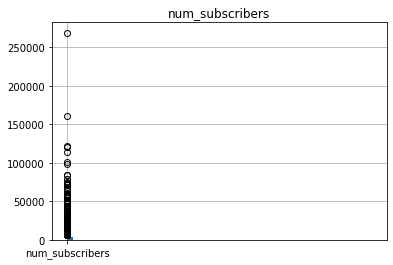

In [ ]:
#TODO: Drop Outliers and show BoxPlot
dataset.hist("num_subscribers",bins=50)
boxplot = dataset.boxplot(column=['num_subscribers'])
dataset.num_subscribers.quantile([0.25,0.5,0.75])
outlier = 2546 + (1.5 * 2546)
dataset_clean = dataset[dataset.num_subscribers <= outlier]

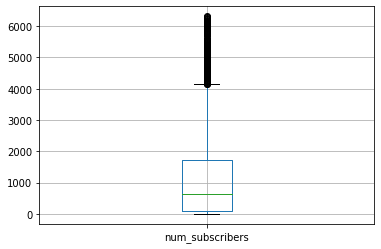

In [ ]:
#Show new Box Plot
boxplot2 = dataset_clean.boxplot(column=['num_subscribers'])

In [ ]:
#Drop course_title and url
dataset2 = dataset_clean.drop(columns=['url']) #'course_title'

#Extract date from timestamp
import datetime as dt
dataset2['published_timestamp'] = dataset2['published_timestamp'].apply(lambda x : pd.to_datetime(str(x)))
#dataset2['date'] = dataset2['published_timestamp'].dt.date
#dataset2['year'] = dataset2['published_timestamp'].dt.year
dataset2['month'] = dataset2['published_timestamp'].dt.month
dataset2 ['hour'] = dataset2['published_timestamp'].dt.hour

#Create season column

def func(x):
    if x in (12,1,2):
        return "Winter"
    elif x in (3,4,5):
        return "Spring"
    elif x in (6,7,8):
        return "Summer"
    else:
        return "Fall"

dataset2['season'] = dataset2['month'].apply(func)
dataset2['time_of_day'] = dataset2.hour.apply(lambda x: "Morning" if x < 12 else "Afternoon")


# display updated DataFrame
dataset2.head()

dataset3 = dataset2.drop(columns=['month', 'hour', 'published_timestamp'])                      
dataset3.head()

#Re-order columns
dataset3 = dataset3[['course_id','course_title', 'is_paid', 'price', 'num_reviews','num_lectures', 'level', 'content_duration', 'subject', 'season', 'time_of_day', 'num_subscribers']]
dataset3.head()

,course_id,course_title,is_paid,price,num_reviews,num_lectures,level,content_duration,subject,season,time_of_day,num_subscribers
0,1070968,Ultimate Investment Banking Course,True,200,23,51,All Levels,1.5,Business Finance,Winter,Afternoon,2147
1,1113822,Complete GST Course & Certification - Grow You...,True,75,923,274,All Levels,39.0,Business Finance,Spring,Afternoon,2792
2,1006314,Financial Modeling for Business Analysts and C...,True,45,74,51,Intermediate Level,2.5,Business Finance,Winter,Afternoon,2174
3,1210588,Beginner to Pro - Financial Analysis in Excel ...,True,95,11,36,All Levels,3.0,Business Finance,Spring,Afternoon,2451
4,1011058,How To Maximize Your Profits Trading Options,True,200,45,26,Intermediate Level,2.0,Business Finance,Winter,Afternoon,1276


In [ ]:
# Use pandas to create dummy variables
dataset4 = pd.get_dummies(data=dataset3, columns=['is_paid', 'level','subject','season','time_of_day'],drop_first=True)

# Create Calculated Column Avg Lecture Duration
dataset4['avg_content_duration_per_lecture'] = round(dataset4.num_lectures/dataset4.content_duration,2)
dataset4['avg_content_duration_per_lecture'] = dataset4['avg_content_duration_per_lecture'].fillna(0)

# Sentiment in naming of Course
from textblob import TextBlob

#load the descriptions into textblob
desc_blob = [TextBlob(desc) for desc in dataset4['course_title']]
#add the sentiment metrics to the dataframe
dataset4['polarity'] = [b.sentiment.polarity for b in desc_blob]
dataset4['subjectivity'] = [b.sentiment.subjectivity for b in desc_blob]

# reorder and eliminate num_reviews, course_title and course_id (not insightful indicators for subscribers)
dataset4 = dataset4[['price', 'num_lectures', 'content_duration','avg_content_duration_per_lecture',
                     'is_paid_True','level_Beginner Level','level_Intermediate Level','level_Expert Level',
                     'subject_Graphic Design','subject_Musical Instruments','subject_Web Development','season_Spring',
                     'season_Summer','season_Winter','time_of_day_Morning','polarity','subjectivity','num_subscribers']]

print(dataset4.shape)
dataset4.head()


(3251, 18)


,price,num_lectures,content_duration,avg_content_duration_per_lecture,is_paid_True,level_Beginner Level,level_Intermediate Level,level_Expert Level,subject_Graphic Design,subject_Musical Instruments,subject_Web Development,season_Spring,season_Summer,season_Winter,time_of_day_Morning,polarity,subjectivity,num_subscribers
0,200,51,1.5,34.00,1,0,0,0,0,0,0,0,0,1,0,0.0,1.0,2147
1,75,274,39.0,7.03,1,0,0,0,0,0,0,1,0,0,0,0.1,0.4,2792
2,45,51,2.5,20.40,1,0,1,0,0,0,0,0,0,1,0,0.0,0.0,2174
3,95,36,3.0,12.00,1,0,0,0,0,0,0,1,0,0,0,0.0,0.0,2451
4,200,26,2.0,13.00,1,0,1,0,0,0,0,0,0,1,0,0.0,0.0,1276


In [ ]:
# Assign X and y values
X = dataset4.iloc[:,0:17].values
y = dataset4.iloc[:,17].values

#Splitting the data into Training Set and Test Set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

#Normalizing the features
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

### Run Analysis on Original "Cleaned" dataset

In [ ]:
#Polynomial Regression
from sklearn.metrics import mean_squared_error
#Fitting Linear Regression
from sklearn.linear_model import LinearRegression
lrObj = LinearRegression()
lrObj.fit(X_train, y_train)
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures
df = pd.DataFrame(columns=['k','MSE'])
columns = list(df)
data = []
k = 2
while k < 6:
    polyFeatureObj = PolynomialFeatures(degree=k)
    X_poly = polyFeatureObj.fit_transform(X_train)
    prObj = LinearRegression()
    prObj.fit(X_poly, y_train)
    y_pred = prObj.predict(polyFeatureObj.fit_transform(X_test))
    MSE = mean_squared_error(y_test, y_pred)
    values = [k,MSE]
    zipped = zip(columns, values)
    a_dictionary = dict(zipped)
    data.append(a_dictionary)
    k = k + 1
df = df.append(data, True)
pd.options.display.float_format = '{:.5f}'.format
print(df)


   k                               MSE
0  2                     1653772.57447
1  3 628386933762533399914872832.00000
2  4        13067949219769618432.00000
3  5         2724080528779417600.00000


training score for alpha=.01: 0.27515399321053746
test score for alpha =.01:  0.245075208931949

 training score for alpha=100: 0.27464036762022404
test score for alpha =100:  0.2456433666807707

 Mean Squared Error on test set Ridge alpha .01 is: 1546940.451917361

 Mean Squared Error on test set Ridge alpha 100 is: 1545776.2217647398


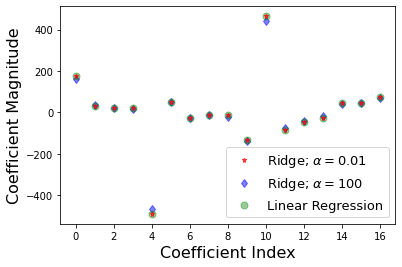

In [ ]:
#Regularization with Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
lrR = LinearRegression()

lrR.fit(X_train, y_train)
rr = Ridge(alpha=0.01) 
# higher the alpha value, more restriction on the coefficients; low alpha > more generalization,
# in this case linear and ridge regression resembles
rr.fit(X_train, y_train)

rr100 = Ridge(alpha=100) #  comparison with alpha value
rr100.fit(X_train, y_train)

train_score=lrR.score(X_train, y_train)
test_score=lrR.score(X_test, y_test)

Ridge_train_score = rr.score(X_train,y_train)
Ridge_test_score = rr.score(X_test, y_test)

Ridge_train_score100 = rr100.score(X_train,y_train)
Ridge_test_score100 = rr100.score(X_test, y_test)

print("training score for alpha=.01:", Ridge_train_score)
print("test score for alpha =.01: ", Ridge_test_score)

print("\n training score for alpha=100:", Ridge_train_score100)
print("test score for alpha =100: ", Ridge_test_score100)


y_pred_RR = rr.predict(X_test) 
mean_squared_error_RR = np.mean((y_pred_RR- y_test)**2)
print("\n Mean Squared Error on test set Ridge alpha .01 is:", mean_squared_error_RR) 

y_pred_RR100 = rr100.predict(X_test) 
mean_squared_error_RR100 = np.mean((y_pred_RR100- y_test)**2)
print("\n Mean Squared Error on test set Ridge alpha 100 is:", mean_squared_error_RR100) 


plt.plot(rr.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 0.01$',zorder=7) 
plt.plot(rr100.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Ridge; $\alpha = 100$') 
plt.plot(lrR.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.show()

training score: 0.27514280455874185
test score:  0.2450621267258499
number of features used:  17

 Lasso training score for alpha=0.01: 0.27515399209061064
Lasso test score for alpha =0.01:  0.24507516645959004
Lasso number of features used: for alpha =0.01: 17

 training score for alpha=0.0001: 0.275153993216237
test score for alpha =0.0001:  0.2450750896040339
number of features used: for alpha =0.0001: 17

 LR training score: 0.2751539932163495
LR test score:  0.24507508889408292

 Mean Squared Error on test set Lasso 1546967.2590828622

 Mean Squared Error on test set Lasso00001 alpha=.0001 1546940.6964359952

 Mean Squared Error on test set Lasso001 alpha =.01 1546940.5389488256


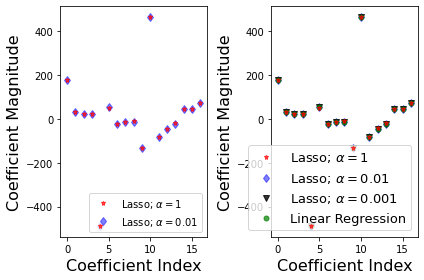

In [ ]:
#regularization with Lasso
import math 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
# difference of lasso and ridge regression is that some of the coefficients can be zero i.e. some of the features are 
# completely neglected
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

lasso = Lasso()
lasso.fit(X_train,y_train)
lasso_train_score=lasso.score(X_train,y_train)
lasso_test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)
print( "training score:", lasso_train_score )
print( "test score: ", lasso_test_score)
print("number of features used: ", coeff_used)

lasso001 = Lasso(alpha=0.01, max_iter=10e5)
lasso001.fit(X_train,y_train)
lasso_train_score001=lasso001.score(X_train,y_train)
lasso_test_score001=lasso001.score(X_test,y_test)
coeff_used001 = np.sum(lasso001.coef_!=0)

print( "\n Lasso training score for alpha=0.01:", lasso_train_score001 )
print( "Lasso test score for alpha =0.01: ", lasso_test_score001)
print( "Lasso number of features used: for alpha =0.01:", coeff_used001)

lasso00001 = Lasso(alpha=0.0001, max_iter=10e5)
lasso00001.fit(X_train,y_train)
lasso_train_score00001=lasso00001.score(X_train,y_train)
lasso_test_score00001=lasso00001.score(X_test,y_test)
coeff_used00001 = np.sum(lasso00001.coef_!=0)
print( "\n training score for alpha=0.0001:", lasso_train_score00001 )
print ("test score for alpha =0.0001: ", lasso_test_score00001)
print( "number of features used: for alpha =0.0001:", coeff_used00001)

lrlas = LinearRegression()
lrlas.fit(X_train,y_train)
lr_train_score=lrlas.score(X_train,y_train)
lr_test_score=lrlas.score(X_test,y_test)
print( "\n LR training score:", lr_train_score )
print( "LR test score: ", lr_test_score)

y_pred_LR2 = lasso.predict(X_test) 
mean_squared_error_LR2 = np.mean((y_pred_LR2- y_test)**2)
print("\n Mean Squared Error on test set Lasso", mean_squared_error_LR2) 


y_pred_LR1 = lasso00001.predict(X_test) 
mean_squared_error_LR1 = np.mean((y_pred_LR1- y_test)**2) 
print("\n Mean Squared Error on test set Lasso00001 alpha=.0001", mean_squared_error_LR1) 


y_pred_LR = lasso001.predict(X_test) 
mean_squared_error_LR = np.mean((y_pred_LR- y_test)**2) 
print("\n Mean Squared Error on test set Lasso001 alpha =.01", mean_squared_error_LR) 

plt.subplot(1,2,1)
plt.plot(lasso.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 1$',zorder=7) # alpha here is for transparency
plt.plot(lasso001.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.01$') # alpha here is for transparency

plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=10,loc=4)
plt.subplot(1,2,2)
plt.plot(lasso.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 1$',zorder=7) # alpha here is for transparency
plt.plot(lasso001.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.01$') # alpha here is for transparency
plt.plot(lasso00001.coef_,alpha=0.8,linestyle='none',marker='v',markersize=6,color='black',label=r'Lasso; $\alpha = 0.001$') # alpha here is for transparency
plt.plot(lrlas.coef_,alpha=0.7,linestyle='none',marker='o',markersize=5,color='green',label='Linear Regression',zorder=2)
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.tight_layout()
plt.show()




In [ ]:
#Regularization with Elastic Net
# import model 
from sklearn.linear_model import ElasticNet 
  
# Train the model 
e_net = ElasticNet(alpha = 1) 
e_net.fit(X_train, y_train) 
  
# calculate the prediction and mean square error 
y_pred_elastic = e_net.predict(X_test) 
mean_squared_error_EN = np.mean((y_pred_elastic - y_test)**2) 
print("Mean Squared Error on test set", mean_squared_error_EN) 

# Train the model 
e_net01 = ElasticNet(alpha = .01) 
e_net01.fit(X_train, y_train) 
  
# calculate the prediction and mean square error 
y_pred_elastic01 = e_net01.predict(X_test) 
mean_squared_error_EN01 = np.mean((y_pred_elastic01 - y_test)**2) 
print("Mean Squared Error on test set apha .01", mean_squared_error_EN01) 


# Train the model 
e_net001 = ElasticNet(alpha = .001) 
e_net001.fit(X_train, y_train) 
  
# calculate the prediction and mean square error 
y_pred_elastic001 = e_net001.predict(X_test) 
mean_squared_error_EN001 = np.mean((y_pred_elastic001 - y_test)**2) 
print("Mean Squared Error on test set apha .001", mean_squared_error_EN001) 

Mean Squared Error on test set 1590279.6358784898
Mean Squared Error on test set apha .01 1546679.714402869
Mean Squared Error on test set apha .001 1546912.9006522151


In [ ]:
# https://www.kaggle.com/jnikhilsai/cross-validation-with-linear-regression

# Run Kfold
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV


# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 17))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)          

cv_results = pd.DataFrame(model_cv.cv_results_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    1.4s finished


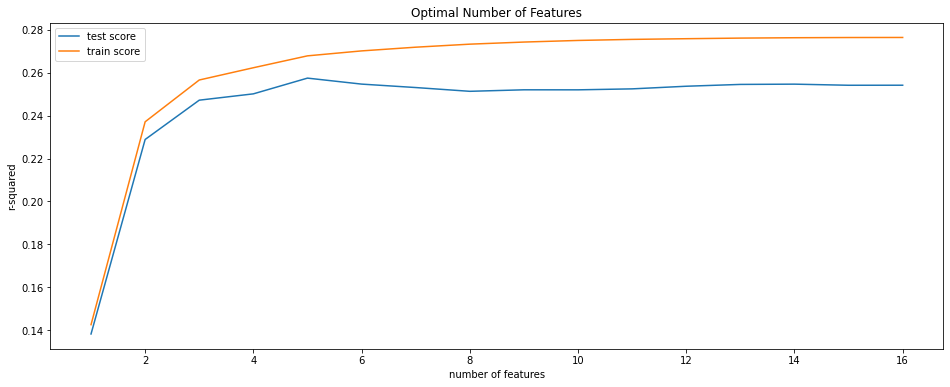

In [ ]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [ ]:
from sklearn.metrics import r2_score
import sklearn
# final model
n_features_optimal = 4

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = lm.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.24507508889408292


In [ ]:
# Bring in library to see more statistical analysis on coefficients
import statsmodels.api as sm
from statsmodels.api import add_constant

# Convert to a float64
X = X.astype('float64')  # Without this, OLS function errors out
X = add_constant(X)

attributes_index = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

# Print out summary with all attributes
X_sig = X[:,attributes_index]
obj_OLS = sm.OLS(endog = y, exog = X_sig).fit()
print(obj_OLS.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     69.27
Date:                Sat, 05 Dec 2020   Prob (F-statistic):          3.76e-203
Time:                        16:10:57   Log-Likelihood:                -27723.
No. Observations:                3251   AIC:                         5.548e+04
Df Residuals:                    3233   BIC:                         5.559e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2622.3145    115.513     22.702      0.0

In [ ]:
from sklearn.metrics import mean_squared_error

#Normal Equations
firstTerm = np.linalg.inv(np.dot(X_train.T, X_train))
secondTerm = np.dot(X_train.T, y_train)
Theta = np.dot(firstTerm, secondTerm)
normal_predictions = np.dot(X_test, Theta)
MSE = mean_squared_error(y_true=y_test, y_pred=normal_predictions)

from sklearn.metrics import r2_score
model_acc_dt = r2_score(y_test,normal_predictions)

# Show summary
print("These are weights via Normal Equations:")
print(Theta)
print("\n MSE=" + str(MSE))
print("\n R2 Score is:",model_acc_dt)

These are weights via Normal Equations:
[ 177.21089973   31.07673254   23.87854747   21.50662096 -489.40536488
   52.306094    -25.46763044  -13.91196359  -12.50592983 -134.54857206
  464.309268    -84.28015233  -47.28130853  -24.66971374   44.91397295
   45.23211397   74.37861288]

 MSE=2943710.9499178766

 R2 Score is: -0.43656491177606327


In [ ]:
#Create and Fit a Decision Tree Regressor Object
from sklearn.tree import DecisionTreeRegressor
regObj = DecisionTreeRegressor(criterion = 'mse')
regObj.fit(X_train,y_train) 

#Create Prediction
y_pred_dt = regObj.predict(X_test)
MSE_dt = mean_squared_error(y_true=y_test, y_pred=y_pred_dt)
print("This decision tree's MSE is: ", MSE_dt)
# R² score tells us how well our model is fitted to the data by comparing it to the average line of the dependent variable. 
#If the score is closer to 1, then it indicates that our model performs well versus if the score is farther from 1, then it indicates that our model does not perform so well.
#If the chosen model fits worse than a horizontal line, then R2 is negative. Note that R2 is not always the square of anything, so it can have a negative value without violating any rules of math. 
#R2 is negative only when the chosen model does not follow the trend of the data, so fits worse than a horizontal line
from sklearn.metrics import r2_score
model_acc_dt = r2_score(y_test,y_pred)
print("R2 Score is:",model_acc_dt)

This decision tree's MSE is:  3064088.191342213
R2 Score is: 0.24507508889408292


In [ ]:
#Random Forest Regression

#Create and Fit a Regressor Object
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Create Model
estimators = find_n_estimators(X_train,X_test,y_train,y_test)
regObj = RandomForestRegressor(n_estimators=estimators)
regObj.fit(X_train,y_train)
predictions = regObj.predict(X_test)
model_acc_dt = r2_score(y_test,predictions)

# Use the forest's predict method on the test data

# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# R² score tells us how well our model is fitted to the data by comparing it to the average line of the dependent variable. 
#If the score is closer to 1, then it indicates that our model performs well versus if the score is farther from 1,
# then it indicates that our model does not perform so well.
print("R2 Score is:",model_acc_dt)
print("number of estimators is:",estimators)

Mean Absolute Error: 934.43 degrees.
R2 Score is: 0.1796962410469326
number of estimators is: 35


### Create New Dataset via backward elimination and rerun models on new dataset

In [ ]:
# Attribute Selection: Backward Elimination

# Set Variables
SL = .05 # p-value can not exceed this value

max_pvalue = 1
new_attributes_index = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
new_X_sig = X[:,new_attributes_index]
new_obj_OLS = sm.OLS(endog = y, exog = new_X_sig).fit()
changed_attributes_index = []
attribute_names = []

# Run Backward elimination function
print("This is showing step by step the process of backward elimination:")

while max_pvalue > .05:

    End_Loop = len(new_attributes_index) # Find end for loop
    changed_attributes_index = [] # reset attributes_index

    # reconfigure attributes list
    for x in range(0,End_Loop):
      if max_pvalue == new_obj_OLS.pvalues[x]:
        print("remove attribute" + str(new_attributes_index[x]))
      else:
        changed_attributes_index.append(new_attributes_index[x])

    # Rerun with the elimination of an attribute
    new_X_sig = X[:,changed_attributes_index]
    new_obj_OLS = sm.OLS(endog = y, exog = new_X_sig).fit()
    max_pvalue = max(new_obj_OLS.pvalues)

    # Restructure Index and Rerun function
    print(changed_attributes_index)
      
    new_attributes_index = changed_attributes_index
    End_Loop = len(new_attributes_index)  

# Identify names of attribute via Index
for x in range(0,len(new_attributes_index)):
  if not x == 0:
    pos = new_attributes_index[x] -1 
    colname = dataset4.columns[pos]
    attribute_names.append(colname)

# Print off summary and attribute names
print("\n")
print("These are the attribute names with significance:")
print(attribute_names)
print("\n")
print(new_obj_OLS.summary())

This is showing step by step the process of backward elimination:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
remove attribute3
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
remove attribute14
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17]
remove attribute4
[0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17]
remove attribute9
[0, 1, 2, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17]
remove attribute16
[0, 1, 2, 5, 6, 7, 8, 10, 11, 12, 13, 15, 17]
remove attribute7
[0, 1, 2, 5, 6, 8, 10, 11, 12, 13, 15, 17]
remove attribute8
[0, 1, 2, 5, 6, 10, 11, 12, 13, 15, 17]
remove attribute15
[0, 1, 2, 5, 6, 10, 11, 12, 13, 17]


These are the attribute names with significance:
['price', 'num_lectures', 'is_paid_True', 'level_Beginner Level', 'subject_Musical Instruments', 'subject_Web Development', 'season_Spring', 'season_Summer', 'subjectivity']


                            OLS Regression Results                            
Dep. Variable:                    

In [ ]:
# Create New Dataset with selected features
attribute_names += ['num_subscribers']
dataset5 = dataset4[attribute_names]
print(dataset5.shape)
dataset5.head()

(3251, 10)


,price,num_lectures,is_paid_True,level_Beginner Level,subject_Musical Instruments,subject_Web Development,season_Spring,season_Summer,subjectivity,num_subscribers
0,200,51,1,0,0,0,0,0,1.00000,2147
1,75,274,1,0,0,0,1,0,0.40000,2792
2,45,51,1,0,0,0,0,0,0.00000,2174
3,95,36,1,0,0,0,1,0,0.00000,2451
4,200,26,1,0,0,0,0,0,0.00000,1276


In [ ]:
# Create new test set X
end_x = len(new_attributes_index)

# Assign X and y values
X_new = dataset5.iloc[:,0:9].values
y_new = dataset5.iloc[:,9]


#Splitting the data into Training Set and Test Set
from sklearn.model_selection import train_test_split
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new,y_new,test_size=0.3,random_state=0)

#Normalizing the features
from sklearn.preprocessing import StandardScaler
sc_X_new = StandardScaler()
X_train_new = sc_X.fit_transform(X_train_new)
X_test_new = sc_X.transform(X_test_new)


In [ ]:
#Create Prediction for MLR
#Fitting Multiple Linear Regression to Training Set
from sklearn.linear_model import LinearRegression
mlrObj = LinearRegression()
mlrObj.fit(X_train_new,y_train_new)

#Predicting on the Test Set
y_pred_new = mlrObj.predict(X_test_new)

# R² score tells us how well our model is fitted to the data by comparing it to the average line of the dependent variable. 
#If the score is closer to 1, then it indicates that our model performs well versus if the score is farther from 1, then it indicates that our model does not perform so well.
#If the chosen model fits worse than a horizontal line, then R2 is negative. Note that R2 is not always the square of anything, so it can have a negative value without violating any rules of math. 
#R2 is negative only when the chosen model does not follow the trend of the data, so fits worse than a horizontal line
from sklearn.metrics import r2_score
model_acc_dt = r2_score(y_test_new,y_pred_new)
print("\n R2 Score is:",model_acc_dt)


 R2 Score is: 0.24394858989834678


In [ ]:
from sklearn.metrics import mean_squared_error

#Normal Equations
firstTerm = np.linalg.inv(np.dot(X_train_new.T, X_train_new)) 
secondTerm = np.dot(X_train_new.T, y_train_new)
Theta_new = np.dot(firstTerm, secondTerm)
normal_predictions_new = np.dot(X_test_new, Theta_new)
MSE = mean_squared_error(y_true=y_test_new, y_pred=normal_predictions_new)
model_acc_dt = r2_score(y_test_new,normal_predictions_new)


# Show summary
print("These are weights via Normal Equations:")
print(Theta_new)
print("\n R2 Score is:",model_acc_dt)
print("\n MSE=" + str(MSE))



These are weights via Normal Equations:
[ 177.0745581    53.56120973 -489.3047492    59.3609964  -130.63086294
  467.3057993   -75.48325459  -39.40643149  108.67555518]

 R2 Score is: -0.4399604808666988

 MSE=2950668.918772169


In [ ]:
#Polynomial Regression AFter Backwards
from sklearn.metrics import mean_squared_error
#Fitting Linear Regression
from sklearn.linear_model import LinearRegression
lrObj = LinearRegression()
lrObj.fit(X_train_new, y_train_new)
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures
df = pd.DataFrame(columns=['k','MSE'])
columns = list(df)
data = []
k = 2
while k < 6:
    polyFeatureObj = PolynomialFeatures(degree=k)
    X_poly = polyFeatureObj.fit_transform(X_train_new)
    prObj = LinearRegression()
    prObj.fit(X_poly, y_train_new)
    y_pred = prObj.predict(polyFeatureObj.fit_transform(X_test_new))
    MSE = mean_squared_error(y_test_new, y_pred)
    values = [k,MSE]
    zipped = zip(columns, values)
    a_dictionary = dict(zipped)
    data.append(a_dictionary)
    k = k + 1
df = df.append(data, True)
pd.options.display.float_format = '{:.5f}'.format
print(df)

   k                            MSE
0  2                  1550337.88730
1  3                  1815501.36353
2  4 167429838280599596433408.00000
3  5    110416142154222845952.00000


New training score for alpha=.01: 0.27295598658807096
New test score for alpha =.01:  0.24394867460672565

 New training score for alpha=100: 0.27247200583248665
New test score for alpha =100:  0.24425883230868128

 New Mean Squared Error on test set Ridge alpha .01 is: 1549248.8693104303

 New Mean Squared Error on test set Ridge alpha 100 is: 1548613.315277358


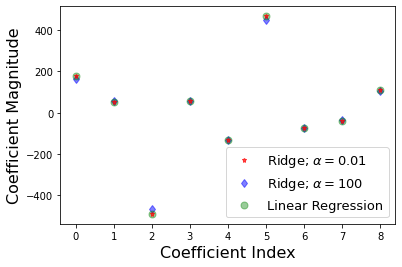

In [ ]:
#Regularization with Ridge AFTER Backwards
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
lrNew = LinearRegression()

lrNew.fit(X_train_new, y_train_new)

rrNew = Ridge(alpha=0.01) 
# higher the alpha value, more restriction on the coefficients; low alpha > more generalization,
# in this case linear and ridge regression resembles
rrNew.fit(X_train_new, y_train_new)

rr100New = Ridge(alpha=100) #  comparison with alpha value
rr100New.fit(X_train_new, y_train_new)

train_scoreNew=lrNew.score(X_train_new, y_train_new)
test_scoreNew=lrNew.score(X_test_new, y_test_new)

Ridge_train_scoreNEW = rrNew.score(X_train_new,y_train_new)
Ridge_test_scoreNEW = rrNew.score(X_test_new, y_test_new)

Ridge_train_score100NEW = rr100New.score(X_train_new,y_train_new)
Ridge_test_score100NEW = rr100New.score(X_test_new, y_test_new)

print("New training score for alpha=.01:", Ridge_train_scoreNEW)
print("New test score for alpha =.01: ", Ridge_test_scoreNEW)

print("\n New training score for alpha=100:", Ridge_train_score100NEW)
print("New test score for alpha =100: ", Ridge_test_score100NEW)


y_pred_RRNew = rrNew.predict(X_test_new) 
mean_squared_error_RRNEW = np.mean((y_pred_RRNew- y_test_new)**2)
print("\n New Mean Squared Error on test set Ridge alpha .01 is:", mean_squared_error_RRNEW) 

y_pred_RR100NEW = rr100New.predict(X_test_new) 
mean_squared_error_RR100NEW = np.mean((y_pred_RR100NEW- y_test_new)**2)
print("\n New Mean Squared Error on test set Ridge alpha 100 is:", mean_squared_error_RR100NEW) 


plt.plot(rrNew.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 0.01$',zorder=7) 
plt.plot(rr100New.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Ridge; $\alpha = 100$') 
plt.plot(lrNew.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.show()

In [ ]:
#Regularization with Elastic Net After Backwards
# import model 
from sklearn.linear_model import ElasticNet 
  
# Train the model 
e_netNew = ElasticNet(alpha = 1) 
e_netNew.fit(X_train_new, y_train_new) 
  
# calculate the prediction and mean square error 
y_pred_elasticNew = e_netNew.predict(X_test_new) 
mean_squared_error_ENNew = np.mean((y_pred_elasticNew - y_test_new)**2) 
print("New Mean Squared Error on test set", mean_squared_error_ENNew) 


# Train the model 
e_net01New = ElasticNet(alpha = .01) 
e_net01New.fit(X_train_new, y_train_new) 
  
# calculate the prediction and mean square error 
y_pred_elastic01New = e_net01New.predict(X_test_new) 
mean_squared_error_EN01New = np.mean((y_pred_elastic01New - y_test_new)**2) 
print("New Mean Squared Error on test set apha .01", mean_squared_error_EN01New) 


# Train the model 
e_net001New = ElasticNet(alpha = .001) 
e_net001New.fit(X_train_new, y_train_new) 
  
# calculate the prediction and mean square error 
y_pred_elastic001New = e_net001New.predict(X_test_new) 
mean_squared_error_EN001New = np.mean((y_pred_elastic001New - y_test_new)**2) 
print("New Mean Squared Error on test set apha .001", mean_squared_error_EN001New) 

New Mean Squared Error on test set 1595486.6405167459
New Mean Squared Error on test set apha .01 1549067.906039478
New Mean Squared Error on test set apha .001 1549229.5242660171


New training score: 0.27295118821189124
New test score:  0.2438763233325224
New number of features used:  9

 New training score for alpha=0.01: 0.2729559861125388
New test score for alpha =0.01:  0.24394790586597692
New number of features used: for alpha =0.01: 9

 New training score for alpha=0.0001: 0.2729559865933784
 New test score for alpha =0.0001:  0.24394858316010604
New number of features used: for alpha =0.0001: 9

 New LR training score: 0.272955986593425
New LR test score:  0.24394858989834678

 New Mean Squared Error on test set Lasso 1549397.1266125327

 New Mean Squared Error on test set Lasso00001 1549249.0566966152

 New Mean Squared Error on test set Lasso001 1549250.4445616005


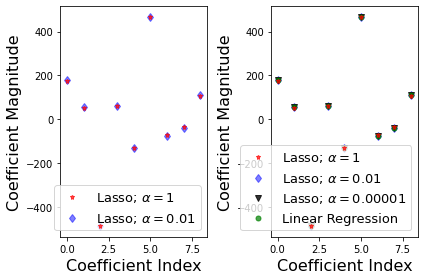

In [ ]:
#regularization with Lasso
import math 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
# difference of lasso and ridge regression is that some of the coefficients can be zero i.e. some of the features are 
# completely neglected
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

lassoNew = Lasso()
lassoNew.fit(X_train_new,y_train_new)
lasso_train_scoreNew=lassoNew.score(X_train_new,y_train_new)
lasso_test_scoreNew=lassoNew.score(X_test_new,y_test_new)
coeff_usedNew = np.sum(lassoNew.coef_!=0)
print( "New training score:", lasso_train_scoreNew )
print( "New test score: ", lasso_test_scoreNew)
print("New number of features used: ", coeff_usedNew)

lasso001New = Lasso(alpha=0.01, max_iter=10e5)
lasso001New.fit(X_train_new,y_train_new)
lasso_train_score001New=lasso001New.score(X_train_new,y_train_new)
lasso_test_score001New=lasso001New.score(X_test_new,y_test_new)
coeff_used001New = np.sum(lasso001New.coef_!=0)

print( "\n New training score for alpha=0.01:", lasso_train_score001New )
print( "New test score for alpha =0.01: ", lasso_test_score001New)
print( "New number of features used: for alpha =0.01:", coeff_used001New)

lasso00001New = Lasso(alpha=0.0001, max_iter=10e5)
lasso00001New.fit(X_train_new,y_train_new)
lasso_train_score00001New=lasso00001New.score(X_train_new,y_train_new)
lasso_test_score00001New=lasso00001New.score(X_test_new,y_test_new)
coeff_used00001New = np.sum(lasso00001New.coef_!=0)
print( "\n New training score for alpha=0.0001:", lasso_train_score00001New )
print (" New test score for alpha =0.0001: ", lasso_test_score00001New)
print( "New number of features used: for alpha =0.0001:", coeff_used00001New)

lrNewL = LinearRegression()
lrNewL.fit(X_train_new,y_train_new)
lr_train_scoreNewL=lrNewL.score(X_train_new,y_train_new)
lr_test_scoreNewL=lrNewL.score(X_test_new,y_test_new)
print( "\n New LR training score:", lr_train_scoreNewL )
print( "New LR test score: ", lr_test_scoreNewL)

y_pred_LR2New = lassoNew.predict(X_test_new) 
mean_squared_error_LR2New = np.mean((y_pred_LR2New- y_test_new)**2)
print("\n New Mean Squared Error on test set Lasso", mean_squared_error_LR2New) 


y_pred_LR1New = lasso00001New.predict(X_test_new) 
mean_squared_error_LR1New = np.mean((y_pred_LR1New- y_test_new)**2) 
print("\n New Mean Squared Error on test set Lasso00001", mean_squared_error_LR1New) 


y_pred_LRNew = lasso001New.predict(X_test_new) 
mean_squared_error_LRNew = np.mean((y_pred_LRNew- y_test_new)**2) 
print("\n New Mean Squared Error on test set Lasso001", mean_squared_error_LRNew) 

plt.subplot(1,2,1)
plt.plot(lassoNew.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 1$',zorder=7) # alpha here is for transparency
plt.plot(lasso001New.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.01$') # alpha here is for transparency

plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.subplot(1,2,2)
plt.plot(lassoNew.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Lasso; $\alpha = 1$',zorder=7) # alpha here is for transparency
plt.plot(lasso001New.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Lasso; $\alpha = 0.01$') # alpha here is for transparency
plt.plot(lasso00001New.coef_,alpha=0.8,linestyle='none',marker='v',markersize=6,color='black',label=r'Lasso; $\alpha = 0.00001$') # alpha here is for transparency
plt.plot(lrNewL.coef_,alpha=0.7,linestyle='none',marker='o',markersize=5,color='green',label='Linear Regression',zorder=2)
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.tight_layout()
plt.show()

In [ ]:
#Check accuracy
#Decision Tree after Backwards
#Create and Fit a Regressor Object
from sklearn.tree import DecisionTreeRegressor
regObj = DecisionTreeRegressor(criterion = 'mse')
regObj.fit(X_train_new,y_train_new) 

#Create Prediction
y_pred_dt_new = regObj.predict(X_test_new)
MSE_dt_new = mean_squared_error(y_true=y_test_new, y_pred=y_pred_dt_new)
print("This decision tree's MSE is: ", MSE_dt_new)
from sklearn.metrics import r2_score
model_acc_dt_new = r2_score(y_test_new,y_pred_dt_new)
print("R2 Score is:",model_acc_dt_new)

This decision tree's MSE is:  2817339.52801258
R2 Score is: -0.3748941996548667


In [ ]:
#Random Forest Regression after backwards elimination

#Create and Fit a Regressor Object
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Create Model
estimators_new = find_n_estimators(X_train_new,X_test_new,y_train_new,y_test_new)
regObj_new = RandomForestRegressor(n_estimators=estimators_new)
regObj.fit(X_train_new,y_train_new)
predictions_new = regObj.predict(X_test_new)
model_acc_dt_new = r2_score(y_test_new,predictions_new)

# Use the forest's predict method on the test data

# Calculate the absolute errors
errors_new = abs(predictions_new - y_test_new)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_new), 2), 'degrees.')

#r2 score
from sklearn.metrics import r2_score
RF2 = r2_score(y_test_new, predictions_new)
print("\n The r2 is: ", RF2)

# R² score tells us how well our model is fitted to the data by comparing it to the average line of the dependent variable. 
#If the score is closer to 1, then it indicates that our model performs well versus if the score is farther from 1, 
#then it indicates that our model does not perform so well.
print("Model Score is:",model_acc_dt_new)
print("number of estimators is:",estimators_new)

Mean Absolute Error: 1152.33 degrees.

 The r2 is:  -0.38792868423605076
Model Score is: -0.38792868423605076
number of estimators is: 32


In [ ]:
# Run Kfold
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV


# step-1: create a cross-validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# step-2: specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, 9))}]


# step-3: perform grid search
# 3.1 specify model
lm = LinearRegression()
lm.fit(X_train_new, y_train_new)
rfe = RFE(lm)             

# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train_new, y_train_new)          

cv_results = pd.DataFrame(model_cv.cv_results_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.4s finished


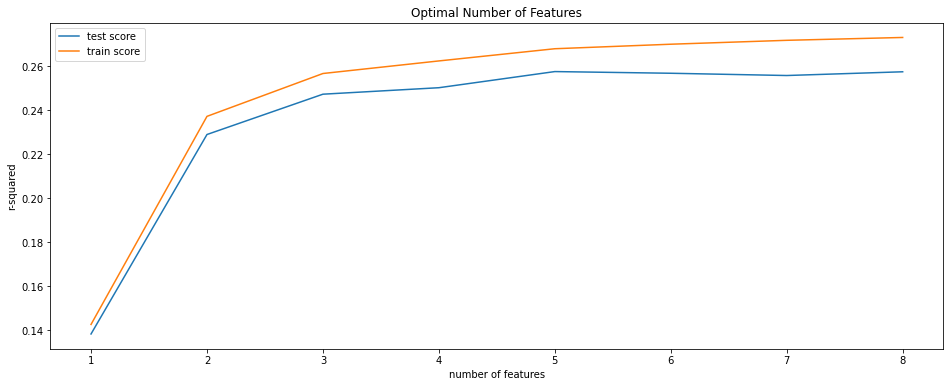

In [ ]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [ ]:
# In reference to the graph, you can see that much of the variance is described by ispaid_true and subject_webdevelopment(22.8%)
attributes_index=[0, 1, 5, 11]

# Print out summary with all attributes
X_sig = X[:,attributes_index]
obj_OLS = sm.OLS(endog = y, exog = X_sig).fit()
print(obj_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     355.7
Date:                Sat, 05 Dec 2020   Prob (F-statistic):          1.04e-199
Time:                        16:12:34   Log-Likelihood:                -27766.
No. Observations:                3251   AIC:                         5.554e+04
Df Residuals:                    3247   BIC:                         5.556e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2586.7313     91.275     28.340      0.0

In [ ]:
#Applying PCA
from sklearn.decomposition import PCA
n = 1
df_pca = pd.DataFrame(columns=['n_components','r2','MSE'])
columns = list(df_pca)
data_pca = []
while n < 18: 
    pcaObj = PCA(n_components=n)
    X_train_pca_lr = pcaObj.fit_transform(X_train)
    X_test_pca_lr = pcaObj.transform(X_test)
    components_variance = pcaObj.explained_variance_ratio_
    from sklearn.linear_model import LinearRegression
    lrObj_pca = LinearRegression()
    lrObj_pca.fit(X_train_pca_lr, y_train)
    predictions_pca_lr = lrObj_pca.predict(X_test_pca_lr)
    r2 = r2_score(y_test,predictions_pca_lr)
    from sklearn.metrics import mean_squared_error
    MSEPCA = (mean_squared_error(y_test, predictions_pca_lr))
    values = [n,r2, MSEPCA]
    zipped = zip(columns, values)
    a_dictionary = dict(zipped)
    data_pca.append(a_dictionary)
    n = n + 1
df_pca = df_pca.append(data_pca, True)
pd.options.display.float_format = '{:.5f}'.format
print(df_pca)

   n_components      r2           MSE
0             1 0.02743 1992934.32132
1             2 0.03005 1987546.23724
2             3 0.05887 1928494.21944
3             4 0.05616 1934062.29797
4             5 0.05607 1934238.39594
5             6 0.06697 1911891.44776
6             7 0.18046 1679353.33008
7             8 0.18436 1671347.21851
8             9 0.18501 1670021.65034
9            10 0.19584 1647820.51756
10           11 0.21172 1615286.45406
11           12 0.22744 1583070.39938
12           13 0.23704 1563404.04457
13           14 0.24527 1546535.31193
14           15 0.24535 1546372.17349
15           16 0.24547 1546136.65137
16           17 0.24508 1546940.69789


Text(0.5, 1.0, 'Optimal Number of PCA n_components, r')

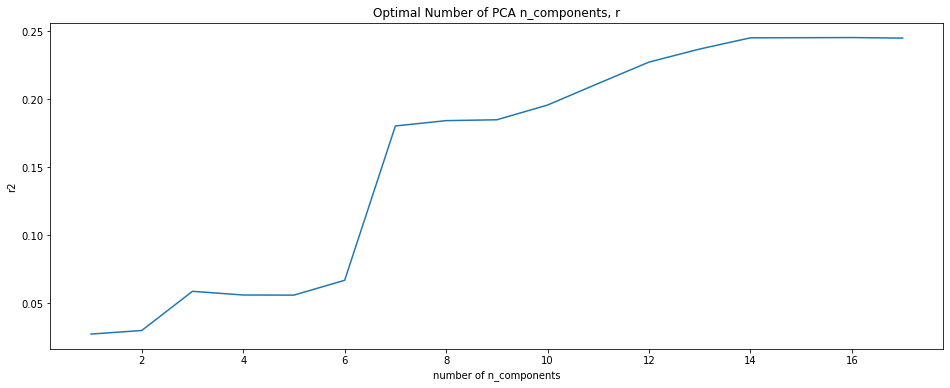

In [ ]:
# plotting pca accuracy
plt.figure(figsize=(16,6))

plt.plot(df_pca["n_components"], df_pca["r2"])
plt.xlabel('number of n_components')
plt.ylabel('r2')
plt.title("Optimal Number of PCA n_components, r")

Text(0.5, 1.0, 'Optimal Number of PCA n_components, MSE')

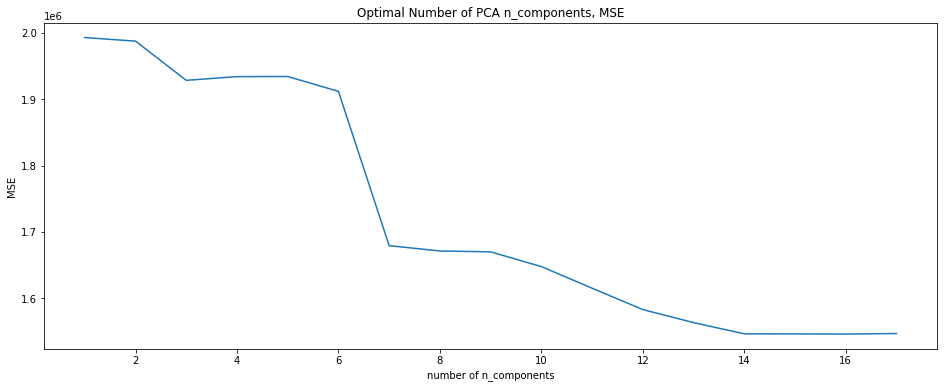

In [ ]:
# plotting pca accuracy
plt.figure(figsize=(16,6))

plt.plot(df_pca["n_components"], df_pca["MSE"])
plt.xlabel('number of n_components')
plt.ylabel('MSE')
plt.title("Optimal Number of PCA n_components, MSE")

In [ ]:
#kernel PCA
from sklearn.decomposition import KernelPCA
kernelPCAObj = KernelPCA(n_components=10, kernel='rbf')  
X_trainKPCA = kernelPCAObj.fit_transform(X_train)
X_testKPCA = kernelPCAObj.transform(X_test)

#Fitting  Regression to Training Set
from sklearn.linear_model import LinearRegression
LinObjKPCA = LinearRegression() 
LinObjKPCA.fit(X_trainKPCA, y_train)



#Making predictions on the Test Set
y_predKPCA = LinObjKPCA.predict(X_testKPCA)


from sklearn.metrics import mean_squared_error
MSEKPCA=(mean_squared_error(y_test, y_predKPCA))
print('The Mean Squared Error after Kernel PCA is: ', MSEKPCA)

 

The Mean Squared Error after Kernel PCA is:  1638054.147379438
